# <font style="color:blue">Convolutional Neural Networks </font>
In this Notebook, we will construct the LeNet architecture and train the same using MNIST dataset.

Yann LeCun, Leon Bottou, Yosuha Bengio and Patrick Haffner proposed this neural network architecture for handwritten and machine-printed character recognition in 1998.

The main purpose of this notebook is to make you familiar with the different layers involved in creating a CNN and how to create a network using them. The training pipeline is similar to what we did for MLP in the last week.

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt  # one of the best graphics library for python

In [3]:
import os
import time

from typing import Iterable
from dataclasses import dataclass

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchvision import datasets, transforms

# <font style="color:blue">1. LeNet5 Architecture</font>

This network has two convolutional layers and three fully connected layers.

The model architecture has been divided into 2 parts

1. **`body`**: This implements the Convolutional part of the network which consists of the 2 convolutional layers with each conv layer followed by a pooling layer. This can also be treated as a Feature extractor in classical ML terms.
1. **`head`**: This implements the Fully Connected part of the network. It consists of 3 fully connected layers with the last layer having the 10 output classes. This can also be treated as the classifier.

Finally after creating the network, we also define the forward function which is executed when we pass an image through the network.

### <font style="color:green">Convolutional Layer Function Syntax </font>

```
torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros')
```
Where,

- **`in_channels`**: number of input channels. For example, for colored images inputs, `in_channel` must be `3`, if `out_channels` of the last `conv2d` is `6` then `in_channels` of the `conv2d` layer must be `6`.

- **`out_channel`:**  number of filters.

- **`kernel_size`:** `int` or `tuple of int`. If it is `int`,  height and width will be the same. If it is `tuple of int`, the first element will be the height (number of rows) of filter and second element will be the width (number of columns) of the filter.

- **`padding`:** padding can also be `int` or `tuple of int`. Similar to `kernel_size`, if it is `int` same padding will be done across the height and width.  The default is zero padding.

Rest of the arguments can be ignored for now. To know more about this, read [here](https://pytorch.org/docs/stable/nn.html#torch.nn.Conv2d).

**Note:** There is no activation after the last linear layer. So during inference, if we want probability as an output, we need to pass the model output through `softmax`.

In [4]:
class LeNet5(nn.Module):
    def __init__(self):
        super().__init__()

        # convolution layers
        self._body = nn.Sequential(
            # First convolution Layer
            # input size = (32, 32), output size = (28, 28)
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5),
            # ReLU activation
            nn.ReLU(inplace=True),
            # Max pool 2-d
            nn.MaxPool2d(kernel_size=2),
            
            # Second convolution layer
            # input size = (14, 14), output size = (10, 10)
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            # output size = (5, 5)
        )
        
        # Fully connected layers
        self._head = nn.Sequential(
            # First fully connected layer
            # in_features = total number of weights in last conv layer = 16 * 5 * 5
            nn.Linear(in_features=16 * 5 * 5, out_features=120), 
            
            # ReLU activation
            nn.ReLU(inplace=True),
            
            # second fully connected layer
            # in_features = output of last linear layer = 120 
            nn.Linear(in_features=120, out_features=84), 
            
            # ReLU activation
            nn.ReLU(inplace=True),
            
            # Third fully connected layer. It is also output layer
            # in_features = output of last linear layer = 84
            # and out_features = number of classes = 10 (MNIST data 0-9)
            nn.Linear(in_features=84, out_features=10)
        )

    def forward(self, x):
        # apply feature extractor
        x = self._body(x)
        # flatten the output of conv layers
        # dimension should be batch_size * number_of weights_in_last conv_layer
        x = x.view(x.size()[0], -1)
        # apply classification head
        x = self._head(x)
        return x

# <font style="color:blue">2. Display the Network</font>

In [5]:
lenet5_model = LeNet5()
print(lenet5_model)

LeNet5(
  (_body): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (_head): Sequential(
    (0): Linear(in_features=400, out_features=120, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=84, out_features=10, bias=True)
  )
)


# <font style="color:blue">3. Get MNIST Data</font>
We load the train and test data using the dataloader class in PyTorch. The dataloader gives us an iterator that spits out batches of data whenever you ask for it. We also apply a few transformations to the data using the [transforms.Compose](https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.Compose) function:
```
train_test_transforms = transforms.Compose([
        # Resize to 32X32
        transforms.Resize((32, 32)),
        # this re-scales image tensor values between 0-1. image_tensor /= 255
        transforms.ToTensor(),
        # subtract mean (0.1307) and divide by variance (0.3081)
        transforms.Normalize((0.1307, ), (0.3081, ))
    ])
```
The following is being performed on the input data:
1. Resizing to `32 x 32`, because the input to the model is of this size. Get more details of ` transforms.Resize` [here](https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.Resize).

2. Re-scaling image tensor values between 0-1. We are dividing each pixel by 255. Get more details of `transforms.ToTensor` [here](https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.ToTensor).

3. We are normalizing the data by subtracting mean and dividing by variance. This is also known as standardization. Get more details of `transforms.Normalize` [here](https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.Normalize).


In [6]:
def get_data(batch_size, data_root='data', num_workers=1):
    
    train_test_transforms = transforms.Compose([
        # Resize to 32X32
        transforms.Resize((32, 32)),
        # this re-scales image tensor values between 0-1. image_tensor /= 255
        transforms.ToTensor(),
        # subtract mean (0.1307) and divide by variance (0.3081).
        # This mean and variance is calculated on training data (verify yourself)
        transforms.Normalize((0.1307, ), (0.3081, ))
    ])
    
    # train dataloader
    train_loader = torch.utils.data.DataLoader(
        datasets.MNIST(root=data_root, train=True, download=True, transform=train_test_transforms),
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers
    )
    
    # test dataloader
    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST(root=data_root, train=False, download=True, transform=train_test_transforms),
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers
    )
    return train_loader, test_loader

# <font style="color:blue">4. System Configuration</font>

It is always good practice to have the configuration parameters in different files. Since we are using a single notebook in this case, we will create a class for it and later see how to **structure the project** so that these can be kept in separate files.

In **`SystemConfiguration`** class, we have defined a few attributes. These attributes are mainly for having reproducible results every time we run the notebook. This is a good practise in general.

In [7]:
@dataclass
class SystemConfiguration:
    '''
    Describes the common system setting needed for reproducible training
    '''
    seed: int = 42  # seed number to set the state of all random number generators
    cudnn_benchmark_enabled: bool = True  # enable CuDNN benchmark for the sake of performance
    cudnn_deterministic: bool = True  # make cudnn deterministic (reproducible training)

# <font style="color:blue">5. Training Configuration</font>

In **`TrainingConfiguration`**  class,  we have specified the configuration parameters of the training process. We are already familiar with these configurations. This is also a good practice since you don't need to change the network architecture so often as you change the training parameters. So, keeping them in a separate file/class helps you keep your code modular and clean.


In [8]:
@dataclass
class TrainingConfiguration:
    '''
    Describes configuration of the training process
    '''
    batch_size: int = 32  # amount of data to pass through the network at each forward-backward iteration
    epochs_count: int = 20  # number of times the whole dataset will be passed through the network
    learning_rate: float = 0.01  # determines the speed of network's weights update
    log_interval: int = 100  # how many batches to wait between logging training status
    test_interval: int = 1  # how many epochs to wait before another test. Set to 1 to get val loss at each epoch
    data_root: str = "data"  # folder to save MNIST data (default: data/mnist-data)
    num_workers: int = 10  # number of concurrent processes used to prepare data
    device: str = 'cuda'  # device to use for training.
    


# <font style="color:blue">6. System Setup</font>

Let us define a function, **`setup_system`** that will check the `SystemConfiguration` attributes and update the system settings accordingly. For example, it sets the device to GPU/CPU depending on GPU availability on your system.

In [9]:
def setup_system(system_config: SystemConfiguration) -> None:
    torch.manual_seed(system_config.seed)
    if torch.cuda.is_available():
        torch.backends.cudnn_benchmark_enabled = system_config.cudnn_benchmark_enabled
        torch.backends.cudnn.deterministic = system_config.cudnn_deterministic

# <font style="color:blue">7. Training</font>
We are familiar with the training pipeline used in PyTorch. The following steps are performed in the code below:

1. Send the data to the required device ( CPU/GPU ).
1. Make a forward pass using the forward method.
1. Find the loss using the Cross_Entropy function.
1. Find the gradients using the backward function.
1. Update the weights using the optimizer.
1. Find the accuracy of the model.

Repeat the above for the specified number of epochs.

In [10]:
def train(
    train_config: TrainingConfiguration, model: nn.Module, optimizer: torch.optim.Optimizer,
    train_loader: torch.utils.data.DataLoader, epoch_idx: int
) -> None:
    
    # change model in training mode
    model.train()
    
    # to get batch loss
    batch_loss = np.array([])
    
    # to get batch accuracy
    batch_acc = np.array([])
        
    for batch_idx, (data, target) in enumerate(train_loader):
        
        # clone target
        indx_target = target.clone()
        # send data to device (it is mandatory if GPU has to be used)
        data = data.to(train_config.device)
        # send target to device
        target = target.to(train_config.device)

        # reset parameters gradient to zero
        optimizer.zero_grad()
        
        # forward pass to the model
        output = model(data)
        
        # cross entropy loss
        loss = F.cross_entropy(output, target)
        
        # find gradients w.r.t training parameters
        loss.backward()
        # Update parameters using gradients
        optimizer.step()
        
        batch_loss = np.append(batch_loss, [loss.item()])
        
        # get probability score using softmax
        prob = F.softmax(output, dim=1)
            
        # get the index of the max probability
        pred = prob.data.max(dim=1)[1]  
                        
        # correct prediction
        correct = pred.cpu().eq(indx_target).sum()
            
        # accuracy
        acc = float(correct) / float(len(data))
        
        batch_acc = np.append(batch_acc, [acc])

        if batch_idx % train_config.log_interval == 0 and batch_idx > 0:              
            print(
                'Train Epoch: {} [{}/{}] Loss: {:.6f} Acc: {:.4f}'.format(
                    epoch_idx, batch_idx * len(data), len(train_loader.dataset), loss.item(), acc
                )
            )
            
    epoch_loss = batch_loss.mean()
    epoch_acc = batch_acc.mean()
    return epoch_loss, epoch_acc

# <font style="color:blue">8. Validation</font>

After every few epochs **`validation`** will be called with the `trained model` and `test_loader` to get validation loss and accuracy.

In [11]:
def validate(
    train_config: TrainingConfiguration,
    model: nn.Module,
    test_loader: torch.utils.data.DataLoader,
) -> float:
    model.eval()
    test_loss = 0
    count_corect_predictions = 0
    for data, target in test_loader:
        indx_target = target.clone()
        data = data.to(train_config.device)
        
        target = target.to(train_config.device)
        
        output = model(data)
        # add loss for each mini batch
        test_loss += F.cross_entropy(output, target).item()
        
        # get probability score using softmax
        prob = F.softmax(output, dim=1)
        
        # get the index of the max probability
        pred = prob.data.max(dim=1)[1] 
        
        # add correct prediction count
        count_corect_predictions += pred.cpu().eq(indx_target).sum()

    # average over number of mini-batches
    test_loss = test_loss / len(test_loader)  
    
    # average over number of dataset
    accuracy = 100. * count_corect_predictions / len(test_loader.dataset)
    
    print(
        '\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, count_corect_predictions, len(test_loader.dataset), accuracy
        )
    )
    return test_loss, accuracy/100.0

# <font style="color:blue">9. Main</font>

In this section of code, we use the configuration parameters defined above and start the training. Here are the important actions being taken in the code below:

1. Set up system parameters like CPU/GPU, number of threads etc.
1. Load the data using dataloaders.
1. Create an instance of the LeNet model.
1. Specify optimizer to use.
1. Set up variables to track loss and accuracy and start training.

In [12]:
def main(system_configuration=SystemConfiguration(), training_configuration=TrainingConfiguration()):
    
    # system configuration
    setup_system(system_configuration)

    # batch size
    batch_size_to_set = training_configuration.batch_size
    # num_workers
    num_workers_to_set = training_configuration.num_workers
    # epochs
    epoch_num_to_set = training_configuration.epochs_count

    # if GPU is available use training config, 
    # else lower batch_size, num_workers and epochs count
    if torch.cuda.is_available():
        device = "cuda"
    else:
        device = "cpu"
        batch_size_to_set = 16
        num_workers_to_set = 2
        epoch_num_to_set = 5

    # data loader
    train_loader, test_loader = get_data(
        batch_size=batch_size_to_set,
        data_root=training_configuration.data_root,
        num_workers=num_workers_to_set
    )
    
    # Update training configuration
    training_configuration = TrainingConfiguration(
        device=device,
        epochs_count=epoch_num_to_set,
        batch_size=batch_size_to_set,
        num_workers=num_workers_to_set
    )

    # initiate model
    model = LeNet5()
        
    # send model to device (GPU/CPU)
    model.to(training_configuration.device)

    # optimizer
    optimizer = optim.SGD(
        model.parameters(),
        lr=training_configuration.learning_rate
    )

    best_loss = torch.tensor(np.inf)
    
    # epoch train/test loss
    epoch_train_loss = np.array([])
    epoch_test_loss = np.array([])
    
    # epoch train/test accuracy
    epoch_train_acc = np.array([])
    epoch_test_acc = np.array([])
    
    # training time measurement
    t_begin = time.time()
    for epoch in range(training_configuration.epochs_count):
        
        train_loss, train_acc = train(training_configuration, model, optimizer, train_loader, epoch)
        
        epoch_train_loss = np.append(epoch_train_loss, [train_loss])
        
        epoch_train_acc = np.append(epoch_train_acc, [train_acc])

        elapsed_time = time.time() - t_begin
        speed_epoch = elapsed_time / (epoch + 1)
        speed_batch = speed_epoch / len(train_loader)
        eta = speed_epoch * training_configuration.epochs_count - elapsed_time
        
        print(
            "Elapsed {:.2f}s, {:.2f} s/epoch, {:.2f} s/batch, ets {:.2f}s".format(
                elapsed_time, speed_epoch, speed_batch, eta
            )
        )

        if epoch % training_configuration.test_interval == 0:
            current_loss, current_accuracy = validate(training_configuration, model, test_loader)
            
            epoch_test_loss = np.append(epoch_test_loss, [current_loss])
        
            epoch_test_acc = np.append(epoch_test_acc, [current_accuracy])
            
            if current_loss < best_loss:
                best_loss = current_loss
                
    print("Total time: {:.2f}, Best Loss: {:.3f}".format(time.time() - t_begin, best_loss))
    
    return model, epoch_train_loss, epoch_train_acc, epoch_test_loss, epoch_test_acc

In [13]:
model, epoch_train_loss, epoch_train_acc, epoch_test_loss, epoch_test_acc = main()

Train Epoch: 0 [3200/60000] Loss: 2.261759 Acc: 0.3438
Train Epoch: 0 [6400/60000] Loss: 2.066856 Acc: 0.4062
Train Epoch: 0 [9600/60000] Loss: 0.725591 Acc: 0.8125
Train Epoch: 0 [12800/60000] Loss: 0.441980 Acc: 0.8750
Train Epoch: 0 [16000/60000] Loss: 0.788893 Acc: 0.7500
Train Epoch: 0 [19200/60000] Loss: 0.257747 Acc: 0.9375
Train Epoch: 0 [22400/60000] Loss: 0.441675 Acc: 0.9062
Train Epoch: 0 [25600/60000] Loss: 0.234152 Acc: 0.8750
Train Epoch: 0 [28800/60000] Loss: 0.176411 Acc: 0.9688
Train Epoch: 0 [32000/60000] Loss: 0.114743 Acc: 0.9375
Train Epoch: 0 [35200/60000] Loss: 0.186722 Acc: 0.9062
Train Epoch: 0 [38400/60000] Loss: 0.127582 Acc: 0.9688
Train Epoch: 0 [41600/60000] Loss: 0.130673 Acc: 0.9375
Train Epoch: 0 [44800/60000] Loss: 0.471457 Acc: 0.8750
Train Epoch: 0 [48000/60000] Loss: 0.085017 Acc: 1.0000
Train Epoch: 0 [51200/60000] Loss: 0.450019 Acc: 0.9062
Train Epoch: 0 [54400/60000] Loss: 0.061868 Acc: 1.0000
Train Epoch: 0 [57600/60000] Loss: 0.066065 Acc: 0.

Train Epoch: 7 [25600/60000] Loss: 0.081317 Acc: 0.9688
Train Epoch: 7 [28800/60000] Loss: 0.010218 Acc: 1.0000
Train Epoch: 7 [32000/60000] Loss: 0.008923 Acc: 1.0000
Train Epoch: 7 [35200/60000] Loss: 0.032879 Acc: 1.0000
Train Epoch: 7 [38400/60000] Loss: 0.020405 Acc: 1.0000
Train Epoch: 7 [41600/60000] Loss: 0.009028 Acc: 1.0000
Train Epoch: 7 [44800/60000] Loss: 0.012516 Acc: 1.0000
Train Epoch: 7 [48000/60000] Loss: 0.048327 Acc: 0.9688
Train Epoch: 7 [51200/60000] Loss: 0.001256 Acc: 1.0000
Train Epoch: 7 [54400/60000] Loss: 0.197493 Acc: 0.9688
Train Epoch: 7 [57600/60000] Loss: 0.013712 Acc: 1.0000
Elapsed 53.15s, 6.64 s/epoch, 0.00 s/batch, ets 79.72s

Test set: Average loss: 0.0433, Accuracy: 9857/10000 (99%)

Train Epoch: 8 [3200/60000] Loss: 0.034378 Acc: 0.9688
Train Epoch: 8 [6400/60000] Loss: 0.009304 Acc: 1.0000
Train Epoch: 8 [9600/60000] Loss: 0.001309 Acc: 1.0000
Train Epoch: 8 [12800/60000] Loss: 0.068565 Acc: 0.9688
Train Epoch: 8 [16000/60000] Loss: 0.035017 Acc

Train Epoch: 14 [41600/60000] Loss: 0.044048 Acc: 1.0000
Train Epoch: 14 [44800/60000] Loss: 0.000553 Acc: 1.0000
Train Epoch: 14 [48000/60000] Loss: 0.001325 Acc: 1.0000
Train Epoch: 14 [51200/60000] Loss: 0.004287 Acc: 1.0000
Train Epoch: 14 [54400/60000] Loss: 0.011850 Acc: 1.0000
Train Epoch: 14 [57600/60000] Loss: 0.010367 Acc: 1.0000
Elapsed 96.71s, 6.45 s/epoch, 0.00 s/batch, ets 32.24s

Test set: Average loss: 0.0384, Accuracy: 9885/10000 (99%)

Train Epoch: 15 [3200/60000] Loss: 0.000652 Acc: 1.0000
Train Epoch: 15 [6400/60000] Loss: 0.028240 Acc: 1.0000
Train Epoch: 15 [9600/60000] Loss: 0.003543 Acc: 1.0000
Train Epoch: 15 [12800/60000] Loss: 0.009205 Acc: 1.0000
Train Epoch: 15 [16000/60000] Loss: 0.003671 Acc: 1.0000
Train Epoch: 15 [19200/60000] Loss: 0.003211 Acc: 1.0000
Train Epoch: 15 [22400/60000] Loss: 0.016557 Acc: 1.0000
Train Epoch: 15 [25600/60000] Loss: 0.000255 Acc: 1.0000
Train Epoch: 15 [28800/60000] Loss: 0.008381 Acc: 1.0000
Train Epoch: 15 [32000/60000] Lo

# <font style="color:blue">10. Plot Loss</font>

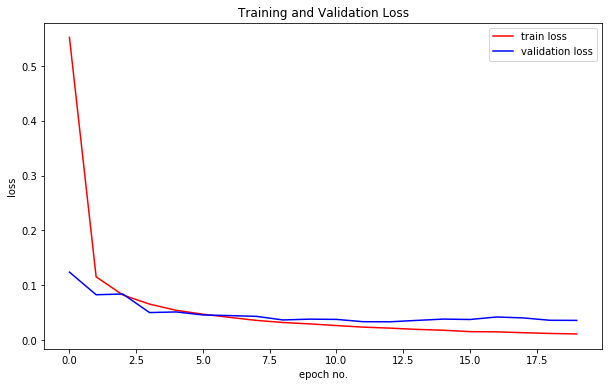

In [14]:
# Plot loss
plt.rcParams["figure.figsize"] = (10, 6)
x = range(len(epoch_train_loss))


plt.figure
plt.plot(x, epoch_train_loss, color='r', label="train loss")
plt.plot(x, epoch_test_loss, color='b', label="validation loss")
plt.xlabel('epoch no.')
plt.ylabel('loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# <font style="color:blue">11. Plot Accuracy</font>

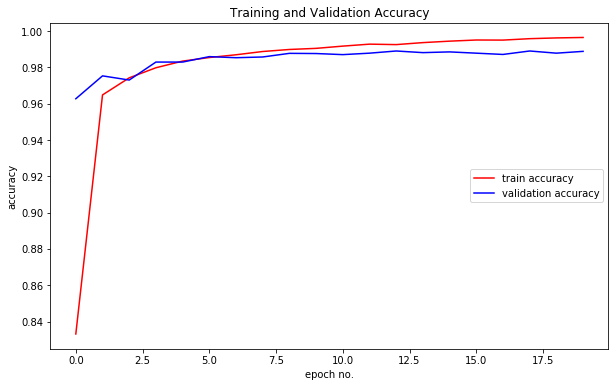

In [15]:
# Plot loss
plt.rcParams["figure.figsize"] = (10, 6)
x = range(len(epoch_train_loss))


plt.figure
plt.plot(x, epoch_train_acc, color='r', label="train accuracy")
plt.plot(x, epoch_test_acc, color='b', label="validation accuracy")
plt.xlabel('epoch no.')
plt.ylabel('accuracy')
plt.legend(loc='center right')
plt.title('Training and Validation Accuracy')
plt.show()

# <font style="color:blue">12. Saving the Model </font>
Once we have trained the model, we should be able to save it. The saved model can be used later for inference or to resume training from where you stopped it ( for example, if you are using free services like Google Colab, etc ). 

The most important thing to understand while saving or loading model is the concept of `state_dict`. We know that the model consists of parameters which are learned during training. These parameters can be accessed using the `model.parameters()` function. Apart from the model parameters, there are some optimizer parameters that contain information about the hyperparameters like learning rate, optimizer used, etc. 

All of the above mentioned information is stored in the form of `state_dict`s. There are separate state_dicts for model parameters (`model.state_dict()`) and optimizer (`optimizer.state_dict()`). 

So, if you want to save the model for performing inference, you should save the state_dict of the model only. On the other hand, if you want to resume training from some checkpoint, you may want to save the optimizer's state_dict as well ( we will talk about checkpoints later ).

Given below is the code which describes how you can save the model.

**Note:** It's good practice to save the `CPU` compatible model. So before saving, we send the model to `CPU` by using `model.to('cpu')`.

In [16]:
models = 'models'
if not os.path.exists(models):
    os.makedirs(models)
    
model_file_name = 'lenet5_mnist.pt'

model_path = os.path.join(models, model_file_name)

# make sure you transfer the model to cpu.
model.to('cpu')

# save the state_dict
torch.save(model.state_dict(), model_path)

# <font style="color:blue">13. Loading the Model </font>
After saving the model's state_dict, you can load the model using similar functions. 

1. Create an instance of the model class.

1. Load the model by using `torch.load(model_path)`.

1. Get model parameters using `model.load_state_dict()`.

In [17]:
# initialize the model
lenet5_mnist = LeNet5()

# loading the model and getting model parameters by using load_state_dict
lenet5_mnist.load_state_dict(torch.load(model_path))

<All keys matched successfully>

# <font style="color:blue">14. Model Prediction</font>

We will use the trained model to perform inference on new data. We just do a forward pass through the network and use a softmax on the output. This will give us a probability score of the prediction.

Finally, we find the argmax of the output which tells us the class to which the prediction belongs.

In [18]:
def prediction(model, train_config, batch_input):
    
    # send model to cpu/cuda according to your system configuration
    model.to(train_config.device)
    
    # it is important to do model.eval() before prediction
    model.eval()

    data = batch_input.to(train_config.device)

    output = model(data)

    # get probability score using softmax
    prob = F.softmax(output, dim=1)

    # get the max probability
    pred_prob = prob.data.max(dim=1)[0]
    
    # get the index of the max probability
    pred_index = prob.data.max(dim=1)[1]
    
    return pred_index.cpu().numpy(), pred_prob.cpu().numpy()

# <font style="color:blue">15. Perform Inference on sample images </font>

For prediction, we need to transform the data in the same way as we have done during training. 

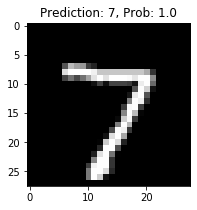

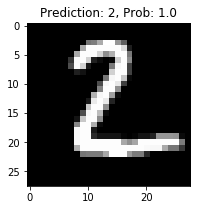

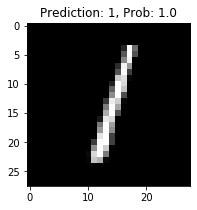

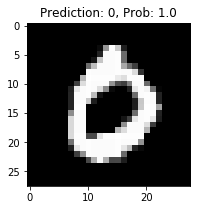

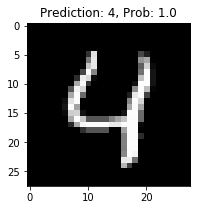

In [19]:
batch_size = 5
train_config = TrainingConfiguration()

if torch.cuda.is_available():
    train_config.device = "cuda"
else:
    train_config.device = "cpu"

# load test data without image transformation
test = torch.utils.data.DataLoader(
    datasets.MNIST(root=train_config.data_root, train=False, download=True, 
                   transform=transforms.functional.to_tensor),
    batch_size=batch_size,
    shuffle=False,
    num_workers=1
    )

image_transforms = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307, ), (0.3081, ))
    ])

test_trans = torch.utils.data.DataLoader(
    datasets.MNIST(root=train_config.data_root, train=False, download=True, transform=image_transforms),
    batch_size=batch_size,
    shuffle=False,
    num_workers=1
    )

for data, _ in test_trans:
    # pass the loaded model
    pred, prob = prediction(lenet5_mnist, train_config, data)
    break
    

plt.rcParams["figure.figsize"] = (3, 3)
for images, _ in test:
    for i, img in enumerate(images):
        img = transforms.functional.to_pil_image(img)
        plt.imshow(img, cmap='gray')
        plt.gca().set_title('Prediction: {0}, Prob: {1:.2}'.format(pred[i], prob[i]))
        plt.show()
    break

# <font style="color:blue">References</font>

1. https://pytorch.org/tutorials/beginner/data_loading_tutorial.html
1. https://pytorch.org/tutorials/beginner/saving_loading_models.html